# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [152]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
pd.options.display.float_format = '{:,.2f}'.format

In [153]:
def load_file(file_path):
    try:
        return pd.read_csv(file_path_name, low_memory=False)
    except:
        print 'Error: Check file path/ name'

In [154]:
# Load the data into a DataFrame
base_path = '../data/'
file_path_name = base_path + 'Iowa_Liquor_Sales_reduced.csv'
df = load_file(file_path_name)

In [155]:
## Transform the dates column
df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%Y')

To ensure accuracy, we are importing a list of Iowa zip codes, cities, counties and county numbers.

In [156]:
file_path_name = base_path + 'ia_zip_city_county_sqm.csv'
location_data = load_file(file_path_name)

In [157]:
location_data.head()

,Unnamed: 0,zip,primary_city,county,state,County#,ZCTA5CE10,area-sqm
0,0,50001,ACKWORTH,Warren,IA,91,50001,62796656
1,1,50002,ADAIR,Guthrie,IA,39,50002,279202219
2,2,50003,ADEL,Dallas,IA,25,50003,298086291
3,3,50005,ALBION,Marshall,IA,64,50005,69623573
4,4,50006,ALDEN,Hardin,IA,42,50006,317745150


In [158]:
location_data.columns = ['number', 'Zip Code', 'City', 'County', 'State','County Number', 'repeat', 'Area (sqkm)']
location_data['Area (sqkm)'] = location_data['Area (sqkm)'] / 1000000

In [159]:
location_data.drop(['number', 'repeat'], axis=1, inplace=True)

We will run a check on zip codes before joining the 2 tables

In [160]:
liquor_zips = df['Zip Code'].drop_duplicates().tolist()
ref_zips = location_data['Zip Code'].astype(str).tolist()
z = [x for x in liquor_zips if x not in ref_zips]
print z

['52733', '52084', '712-2', '52303', '56201', '52087', '52036', '50300']


In [161]:
for i in z:
    print df[['Zip Code', 'City', 'County', 'County Number']][df['Zip Code'] == i].drop_duplicates()
    city = df['City'][df['Zip Code'] == i].drop_duplicates().iloc[0].upper()
    print city
    try:
        print location_data[location_data['City']==city].drop_duplicates()
    except:
        print i, 'not in Iowa'
    print

     Zip Code     City   County  County Number
2932    52733  CLINTON  Clinton          23.00
CLINTON
     Zip Code     City   County State  County Number  Area (sqkm)
901     52732  CLINTON  Clinton    IA             23       310.70

      Zip Code       City County  County Number
28125    52084  DAVENPORT  Scott          82.00
DAVENPORT
     Zip Code       City County State  County Number  Area (sqkm)
934     52801  DAVENPORT  Scott    IA             82         1.36
935     52802  DAVENPORT  Scott    IA             82        29.29
936     52803  DAVENPORT  Scott    IA             82        14.07
937     52804  DAVENPORT  Scott    IA             82        88.86
938     52806  DAVENPORT  Scott    IA             82        79.45
939     52807  DAVENPORT  Scott    IA             82        76.47

       Zip Code    City    County  County Number
28205     712-2  DUNLAP       NaN            nan
563285    712-2  DUNLAP  Harrison          43.00
DUNLAP
     Zip Code    City    County State  Cou

Based on the above, we get a vague idea of what the zips are supposed to be

In [162]:
corrected_zips = ['52403','51529', '52057','52804','0','52732','52601','50309']
for i in range(len(z)):
    df.ix[df['Zip Code']==z[i], 'Zip Code']=corrected_zips[i]

In [163]:
# Run the test again
liquor_zips = df['Zip Code'].drop_duplicates().tolist()
ref_zips = location_data['Zip Code'].astype(str).tolist()
z = [x for x in liquor_zips if x not in ref_zips]
print z

['0']


In [164]:
df['Zip Code'] = df['Zip Code'].astype(int)

Now we merge our location data to our liquor sales

In [165]:
df2 = df.copy()
df2.drop(['County Number', 'City', 'County'], axis=1, inplace=True)
df2 = df2.merge(location_data, how='left', on='Zip Code')
df2.drop(['State'], axis=1, inplace=True)

In [166]:
df2.head()

,Date,Store Number,Zip Code,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),City,County,County Number,Area (sqkm)
0,2016-03-31,5029,52806,"1,022,100.00",TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.50,1.19,DAVENPORT,Scott,82.00,79.45
1,2016-03-31,5029,52806,"1,022,100.00",TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.00,0.53,DAVENPORT,Scott,82.00,79.45
2,2016-03-31,4959,50613,"1,071,100.00",AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,$5.97,$8.96,6,$53.76,10.50,2.77,CEDAR FALLS,Black Hawk,7.00,329.97
3,2016-03-31,2190,50314,"1,031,200.00",VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,$2.24,$3.36,48,$161.28,9.60,2.54,DES MOINES,Polk,77.00,6.63
4,2016-03-31,5240,52358,"1,081,200.00",CREAM LIQUEURS,305,73055,Rumchata,750,$12.50,$18.75,6,$112.50,4.50,1.19,WEST BRANCH,Cedar,16.00,200.94


In [167]:
# Write a function that cross references related columns and fills the data in where it's missing
def fill_missing(related_cols, column, dataframe):
    related_cols.remove(column)
    reference = dataframe[related_cols][dataframe[column].isnull()].drop_duplicates()
    for j in range(len(related_cols)):
        col_1 = reference[related_cols[j]]
        for i in col_1:
            try:
                x = dataframe[column][(dataframe[related_cols[j]]==i) & (dataframe[column].notnull())].drop_duplicates()
                if len(x) < 2:
                    #print 'Missing: {}, Reference: {}, Ref_value: {}, filler: {}'.\
                    #format(column, related_cols[j], i, x.iloc[0])
                    value = x.iloc[0]
                    dataframe.ix[(dataframe[related_cols[j]]==i) & (dataframe[column].isnull()), column] = value
            except:
                pass

In [168]:
fill_missing(['Category', 'Category Name'], 'Category Name', df2)
fill_missing(['Category', 'Category Name'], 'Category', df2)

fill_missing(['Item Number', 'Item Description'], 'Item Description', df2)
fill_missing(['Item Number', 'Item Description'], 'Item Number', df2)

In [169]:
# Convert all dollar columns to floats
df2['State Bottle Cost'] = df2['State Bottle Cost'].map(lambda x: x.strip('$')).astype(float)
df2['State Bottle Retail'] = df2['State Bottle Retail'].map(lambda x: x.strip('$')).astype(float)
df2['Sale (Dollars)'] = df2['Sale (Dollars)'].map(lambda x: x.strip('$')).astype(float)

In [170]:
# Extract Month and Year
df2['Month'] = df2['Date'].map(lambda x: x.month)
df2['Year'] = df2['Date'].map(lambda x: x.year)

In [171]:
df3 = df2.copy()

# Aggregate sales and volume by zip code
agg_sales = pd.pivot_table(df3, index=['Zip Code'], \
               values=['Bottles Sold', 'Volume Sold (Liters)', 'Sale (Dollars)'],\
                     aggfunc=sum).reset_index()
df2 = df2.merge(agg_sales, how='left',on='Zip Code')

# Get number of stores
df3_gb = df2[['Zip Code','Store Number']].drop_duplicates()
df3_gb = df3_gb.rename(columns={'Store Number': 'StoreCount'})
df3_gb = df3_gb.groupby(['Zip Code']).count().reset_index()
df2 = df2.merge(df3_gb, how='left', on='Zip Code')

In [172]:
df2.columns.values

array(['Date', 'Store Number', 'Zip Code', 'Category', 'Category Name',
       'Vendor Number', 'Item Number', 'Item Description',
       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail',
       'Bottles Sold_x', 'Sale (Dollars)_x', 'Volume Sold (Liters)_x',
       'Volume Sold (Gallons)', 'City', 'County', 'County Number',
       'Area (sqkm)', 'Month', 'Year', 'Bottles Sold_y',
       'Sale (Dollars)_y', 'Volume Sold (Liters)_y', 'StoreCount'], dtype=object)

In [173]:
# Rename the columns
df2.columns = ['Date', 'Store Number', 'Zip Code', 'Category', 'Category Name',\
       'Vendor Number', 'Item Number', 'Item Description',\
       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail',\
       'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)',\
       'Volume Sold (Gallons)', 'City', 'County', 'County Number', 'Area (sqkm)','Month',\
       'Year', 'total bottles sold', 'total sales', 'total volume sold', 'Store Count']

In [174]:
# Adding a column for dollar per litre
df2['Dollar per litre'] = df2['total sales']/df2['total volume sold']

In [175]:
# Adding a column for stores per sqkm
df2['Stores per sqkm'] = df2['Store Count']/df2['Area (sqkm)']


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

For the purposes of our market research, we will only be considering full years' data.  
Any year which is not a full year will be dropped.  
We would also like to aggregate sales by zip code and dollar per litre by zip code.  
We also want to know how many stores there are per zip code.

In [176]:
# Find all the full years in the data set
not_full_years = [i for i in df2['Year'].unique() if len(df2['Month'][df2['Year']==i].unique()) != 12]
not_full_years

[2016]

In [177]:
# We're just interested in the following columns
col_required = ['Zip Code',\
                'total bottles sold', 'total sales', 'total volume sold', 'Store Count',\
                'Dollar per litre', 'Area (sqkm)', 'Stores per sqkm', 'Year']
full_df = df2
sales_df = full_df.copy()

In [178]:
for i in not_full_years:
    sales_df = sales_df.drop(sales_df[sales_df['Year']==i].index)
sales_df = sales_df[sales_df['Year']==2015]
sales_df = sales_df[col_required]

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

Our hypothesis is that the demographics of an area would affect the liquor sales there.  
Ideally, we would have wanted to combine our liquor sales data with the demographics data of the corresponding year.  
We were unable to do that and have combined it with the demographics data that we were able to find.  
- This may compromise our model and we should seek to improve it if possible

In [179]:
sales_df.head()

,Zip Code,total bottles sold,total sales,total volume sold,Store Count,Dollar per litre,Area (sqkm),Stores per sqkm,Year
526986,50317,437940,"4,420,837.63","307,951.73",20,14.36,60.04,0.33,2015
526987,50023,154376,"2,240,424.82","142,226.27",9,15.75,57.42,0.16,2015
526988,50317,437940,"4,420,837.63","307,951.73",20,14.36,60.04,0.33,2015
526989,51555,26693,"292,601.73","22,003.52",3,13.30,410.14,0.01,2015
526990,50009,222839,"2,963,462.19","208,620.46",9,14.21,65.21,0.14,2015


In [180]:
# Read in our demographics data
file_path_name = base_path + 'IowaZIPdemos.csv'
demo_df = load_file(file_path_name)

In [181]:
# Remove any rows with null values
# Convert zips to integers for easy comparison
demo_df.dropna(inplace=True)
demo_df['Area'] = demo_df['Area'].astype(int)

In [182]:
demo_cols = demo_df.columns.values.tolist()

object_cols = [i for i in demo_cols if demo_df[i].dtype == 'O']

In [183]:
# Define a function to remove symbols and convert numbers to floats
def rem_symbols(x):
    for i in [',', '%', '$', '-']:
        x = x.replace(i, '')
    try:
        return float(x)
    except:
        print x
    
for i in object_cols:
    demo_df[i] = demo_df[i].map(rem_symbols)

In [184]:
model_df = sales_df.merge(demo_df, how='left', left_on='Zip Code', right_on='Area')

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

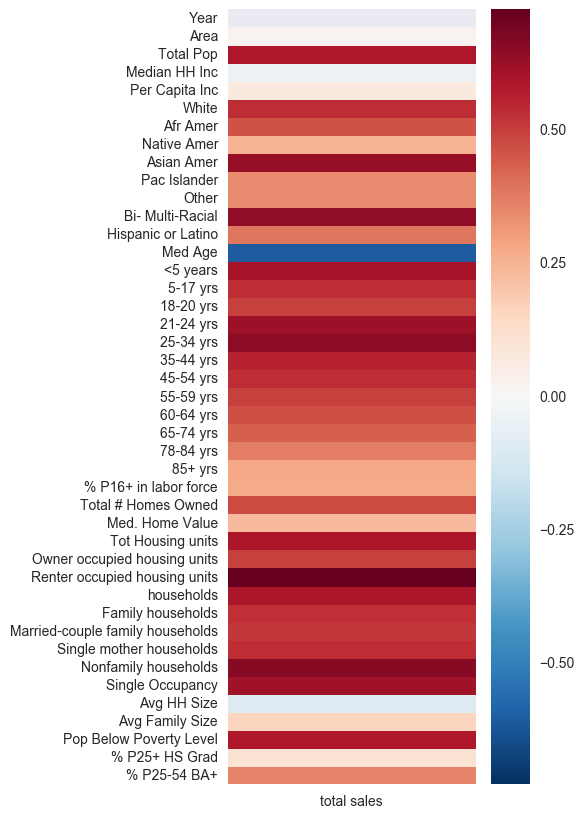

In [185]:
fig, ax = plt.subplots(figsize=(4,10));
sns.heatmap(model_df.corr()[['total sales']].iloc[8:]);

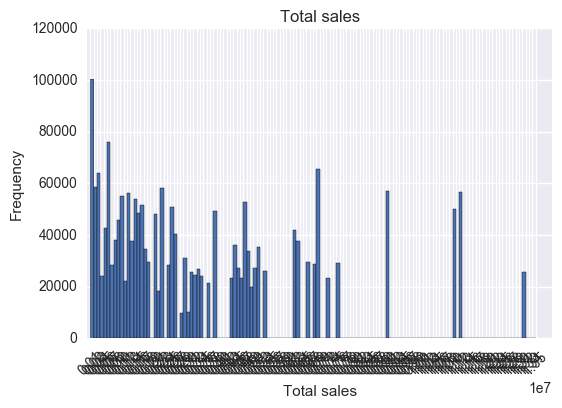

In [186]:
model_df['total sales'].hist(bins=np.arange(100000,max(model_df['total sales']),100000)+0.5);
plt.title('Total sales');
plt.xlabel('Total sales');
plt.ylabel('Frequency');
plt.xticks(np.arange(100000,max(model_df['total sales']),100000),rotation=45);

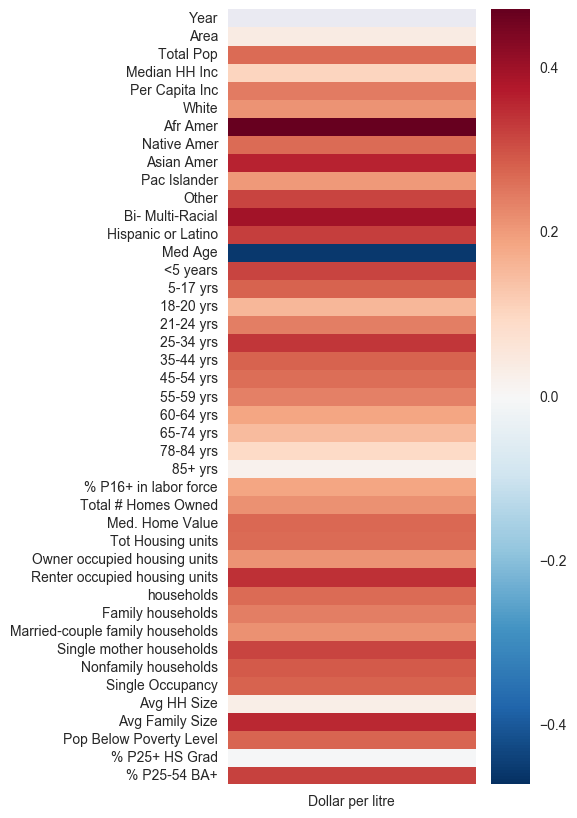

In [187]:
fig, ax = plt.subplots(figsize=(4,10));
sns.heatmap(model_df.corr()[['Dollar per litre']].iloc[8:]);

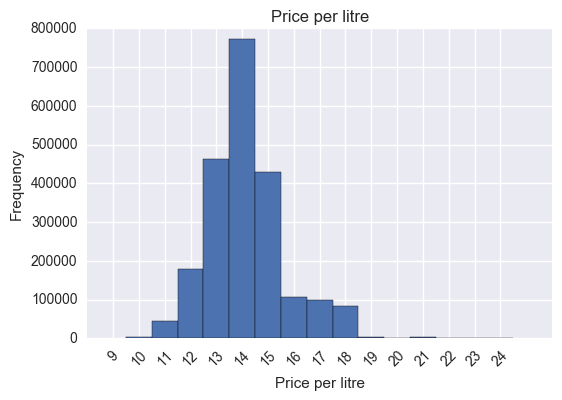

In [188]:
model_df['Dollar per litre'].hist(bins=np.arange(min(model_df['Dollar per litre']).round(),\
                                                 max(model_df['Dollar per litre']).round(),1)+0.5);
plt.title('Price per litre');
plt.xlabel('Price per litre');
plt.ylabel('Frequency');
plt.xticks(np.arange(min(model_df['Dollar per litre']).round(),\
                                                 max(model_df['Dollar per litre']).round(),1),rotation=45);

In [189]:
# Remove outliers in sales that are 3 std away from the median
sales_median = model_df['total sales'].median()
sales_std = model_df['total sales'].std()
model_df = model_df[abs(model_df['total sales'] - sales_median) <= 3*sales_std]

In [190]:
# Remove outliers in dollar per litre that are 3 std away from the median
dollar_median = model_df['Dollar per litre'].median()
dollar_std = model_df['Dollar per litre'].std()
model_df = model_df[abs(model_df['Dollar per litre'] - dollar_median) <= 3*dollar_std]

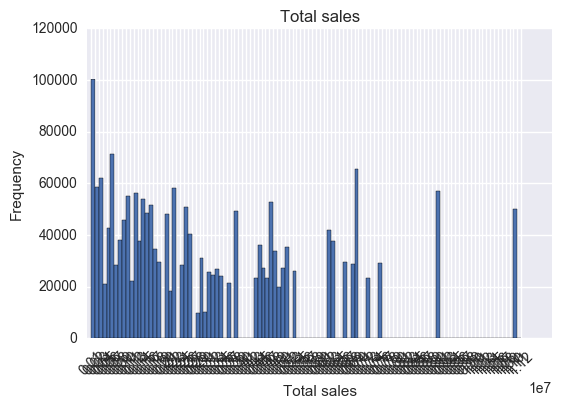

In [191]:
model_df['total sales'].hist(bins=np.arange(100000,max(model_df['total sales']),100000)+0.5);
plt.title('Total sales');
plt.xlabel('Total sales');
plt.ylabel('Frequency');
plt.xticks(np.arange(100000,max(model_df['total sales']),100000),rotation=45);

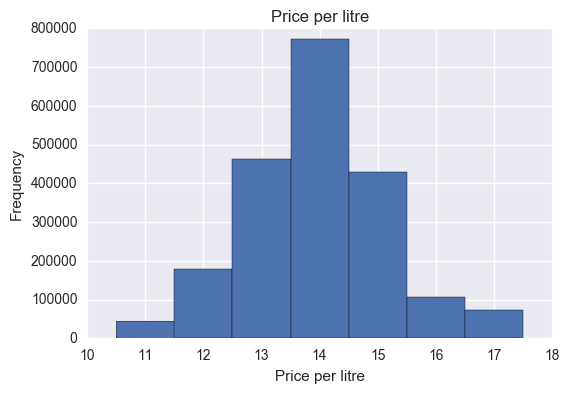

In [192]:
model_df['Dollar per litre'].hist(bins=np.arange(min(model_df['Dollar per litre']).round(),\
                                                 max(model_df['Dollar per litre']).round(),1)+0.5);
plt.title('Price per litre');
plt.xlabel('Price per litre');
plt.ylabel('Frequency');

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [193]:
features = model_df.columns.values.tolist()
print features

['Zip Code', 'total bottles sold', 'total sales', 'total volume sold', 'Store Count', 'Dollar per litre', 'Area (sqkm)', 'Stores per sqkm', 'Year', 'Area', 'Total Pop', 'Median HH Inc', 'Per Capita Inc', 'White', 'Afr Amer', 'Native Amer', 'Asian Amer', 'Pac Islander', 'Other', 'Bi- Multi-Racial', 'Hispanic or Latino', 'Med Age', '<5 years', '5-17 yrs', '18-20 yrs', '21-24 yrs', '25-34 yrs', '35-44 yrs', '45-54 yrs', '55-59 yrs', '60-64 yrs', '65-74 yrs', '78-84 yrs', '85+ yrs', '% P16+ in labor force', 'Total # Homes Owned', 'Med. Home Value', 'Tot Housing units', 'Owner occupied housing units', 'Renter occupied housing units', 'households', 'Family households', 'Married-couple family households', 'Single mother households', 'Nonfamily households', 'Single Occupancy', 'Avg HH Size', 'Avg Family Size', 'Pop Below Poverty Level', '% P25+ HS Grad', '% P25-54 BA+']


In [194]:
drop_features = ['Zip Code', 'total bottles sold', 'total sales',\
                 'total volume sold', 'Store Count', 'Dollar per litre', 'Area (sqkm)', 'Stores per sqkm', 'Area']
for i in drop_features:
    features.remove(i)


In [195]:
model_df.dropna(inplace=True)
X = model_df[features]

r-squared: 0.868193788051
alpha applied: 10.0


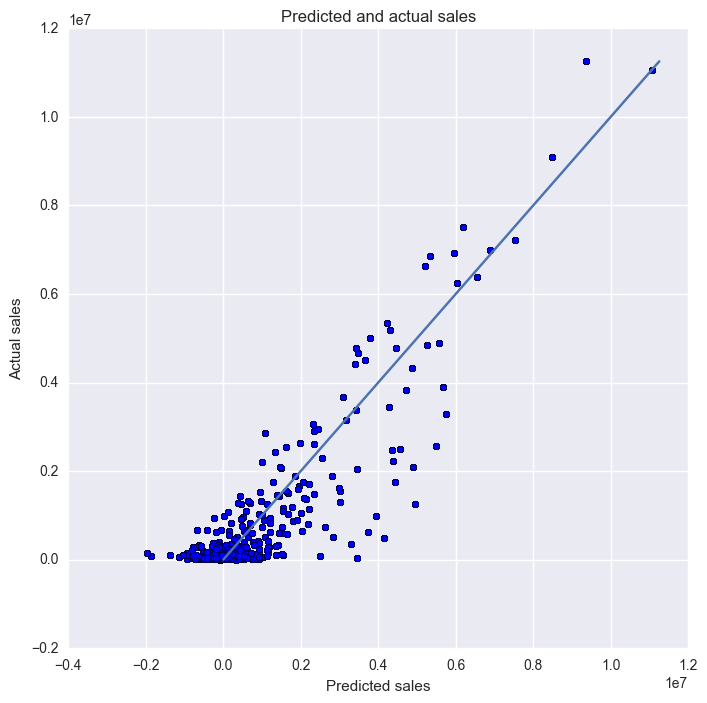

In [196]:
y_sales = model_df['total sales']
ridge = linear_model.RidgeCV(cv=5)
model_sales = ridge.fit(X,y_sales)
print 'r-squared: {}'.format(model_sales.score(X,y_sales))
print 'alpha applied: {}'.format(model_sales.alpha_)

feature_imp = pd.DataFrame([features, model_sales.coef_.tolist()], index=['feature', 'coef']).T
feature_imp['coef'] = feature_imp['coef'].astype(float)
feature_imp = feature_imp.sort_values(by='coef', ascending=False)

predicted_sales = model_sales.predict(X)
fig, ax = plt.subplots(figsize=(8,8));
plt.scatter(predicted_sales, y_sales);
plt.plot([min(y_sales), max(y_sales)], [min(y_sales), max(y_sales)], '-');
plt.title('Predicted and actual sales');
plt.xlabel('Predicted sales');
plt.ylabel('Actual sales');

r-squared: 0.718162145379
alpha applied: 10.0


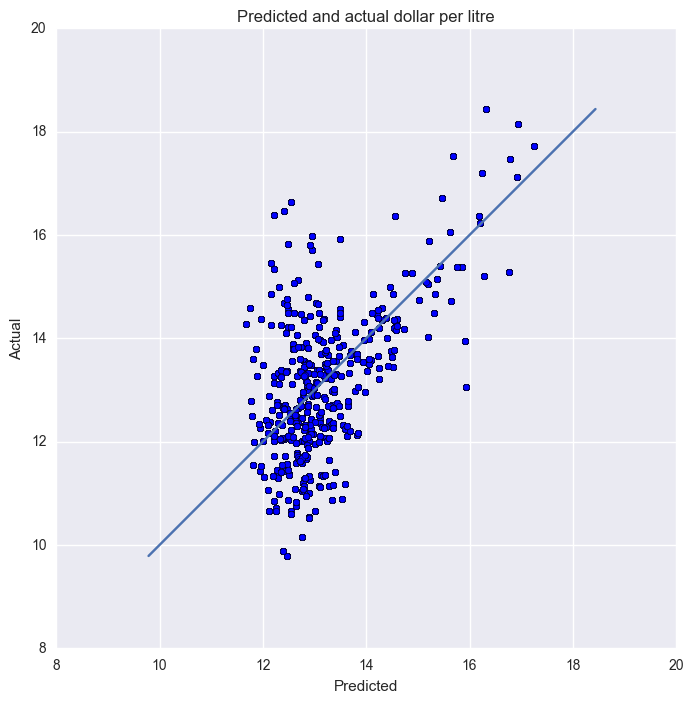

In [197]:
y_dollar = model_df['Dollar per litre']
ridge2 = linear_model.RidgeCV(cv=5)
model_dollar = ridge2.fit(X,y_dollar)
print 'r-squared: {}'.format(model_dollar.score(X,y_dollar))
print 'alpha applied: {}'.format(model_dollar.alpha_)

feature_imp_d = pd.DataFrame([features, model_dollar.coef_.tolist()], index=['feature', 'coef']).T
feature_imp_d['coef'] = feature_imp_d['coef'].astype(float)
feature_imp_d = feature_imp_d.sort_values(by='coef', ascending=False)

predicted_dollar = model_dollar.predict(X)
fig, ax = plt.subplots(figsize=(8,8));
plt.scatter(predicted_dollar, y_dollar);
plt.plot([min(y_dollar), max(y_dollar)], [min(y_dollar), max(y_dollar)], '-');
plt.title('Predicted and actual dollar per litre');
plt.xlabel('Predicted');
plt.ylabel('Actual');

In [198]:
predict_df = location_data.copy()
predict_df['Year'] = 2016
predict_df = predict_df.merge(demo_df, left_on='Zip Code', right_on='Area')

In [199]:
predict_df.head()

,Zip Code,City,County,State,County Number,Area (sqkm),Year,Area,Total Pop,Median HH Inc,...,Family households,Married-couple family households,Single mother households,Nonfamily households,Single Occupancy,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+
0,50001,ACKWORTH,Warren,IA,91,62.80,2016,50001,615.00,"43,611.00",...,174.00,158.00,12.00,42.00,34.00,2.85,3.21,711.00,88.80,9.70
1,50002,ADAIR,Guthrie,IA,39,279.20,2016,50002,"1,339.00","32,500.00",...,370.00,333.00,30.00,205.00,185.00,2.25,2.86,"1,232.00",87.60,11.20
2,50003,ADEL,Dallas,IA,25,298.09,2016,50003,"5,835.00","47,649.00",...,"1,615.00","1,390.00",162.00,619.00,529.00,2.58,3.08,"5,816.00",91.00,24.00
3,50005,ALBION,Marshall,IA,64,69.62,2016,50005,851.00,"41,786.00",...,251.00,208.00,28.00,69.00,56.00,2.66,2.98,917.00,80.80,12.70
4,50006,ALDEN,Hardin,IA,42,317.75,2016,50006,"1,959.00","36,494.00",...,547.00,477.00,43.00,220.00,194.00,2.55,3.09,"1,939.00",88.90,14.80


In [200]:
X_predict = predict_df[features]
all_sales = model_sales.predict(X_predict)
all_dollar_per_litre = model_dollar.predict(X_predict)

In [201]:
all_sales = pd.DataFrame(all_sales, columns=['predicted total sales'])
all_dollar_per_litre = pd.DataFrame(all_dollar_per_litre, columns=['predicted dollar/litre'])

In [202]:
predict_df['predicted total sales'] = all_sales['predicted total sales']
predict_df['predicted dollar/litre'] = all_dollar_per_litre['predicted dollar/litre']

In [203]:
predict_df.head()

,Zip Code,City,County,State,County Number,Area (sqkm),Year,Area,Total Pop,Median HH Inc,...,Single mother households,Nonfamily households,Single Occupancy,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+,predicted total sales,predicted dollar/litre
0,50001,ACKWORTH,Warren,IA,91,62.80,2016,50001,615.00,"43,611.00",...,12.00,42.00,34.00,2.85,3.21,711.00,88.80,9.70,"313,301.38",12.28
1,50002,ADAIR,Guthrie,IA,39,279.20,2016,50002,"1,339.00","32,500.00",...,30.00,205.00,185.00,2.25,2.86,"1,232.00",87.60,11.20,"-182,908.32",13.04
2,50003,ADEL,Dallas,IA,25,298.09,2016,50003,"5,835.00","47,649.00",...,162.00,619.00,529.00,2.58,3.08,"5,816.00",91.00,24.00,"1,168,210.19",13.37
3,50005,ALBION,Marshall,IA,64,69.62,2016,50005,851.00,"41,786.00",...,28.00,69.00,56.00,2.66,2.98,917.00,80.80,12.70,"-545,807.73",12.01
4,50006,ALDEN,Hardin,IA,42,317.75,2016,50006,"1,959.00","36,494.00",...,43.00,220.00,194.00,2.55,3.09,"1,939.00",88.90,14.80,"105,146.09",12.83


In [204]:
present_columns = ['Zip Code', 'predicted total sales', 'predicted dollar/litre']

In [205]:
present_df = predict_df[present_columns]

In [206]:
present_df = present_df.merge(df2[['Zip Code', 'Store Count', 'Area (sqkm)', 'Stores per sqkm']],\
                              how='left', on='Zip Code').drop_duplicates()

In [207]:
present_df.head()

,Zip Code,predicted total sales,predicted dollar/litre,Store Count,Area (sqkm),Stores per sqkm
0,50001,"313,301.38",12.28,nan,nan,nan
1,50002,"-182,908.32",13.04,2.00,279.20,0.01
380,50003,"1,168,210.19",13.37,3.00,298.09,0.01
3255,50005,"-545,807.73",12.01,nan,nan,nan
3256,50006,"105,146.09",12.83,2.00,317.75,0.01


In [208]:
present_df.to_csv('predictions.csv')

In [209]:
top_10 = present_df.sort_values(by='predicted total sales', ascending=False).head(10)

In [210]:
top_10

,Zip Code,predicted total sales,predicted dollar/litre,Store Count,Area (sqkm),Stores per sqkm
1851612,52240,"11,075,365.76",15.43,20.00,415.57,0.05
2119781,52402,"9,368,369.94",13.96,30.00,36.42,0.82
25906,50010,"8,473,547.47",14.23,21.00,155.29,0.14
461293,50266,"7,543,544.63",17.24,16.00,43.06,0.37
1547503,51501,"6,878,669.84",14.88,26.00,68.66,0.38
1687728,52001,"6,563,233.97",15.02,18.00,75.06,0.24
2678004,52807,"6,188,225.81",15.86,9.00,76.47,0.12
1033450,50613,"6,043,356.91",14.39,16.00,329.97,0.05
526354,50311,"5,946,329.49",15.31,7.00,6.51,1.07
625656,50315,"5,740,926.48",14.60,11.00,26.56,0.41


## Record your findings

Be sure to write out anything observations from your exploratory analysis.

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.